In [4]:
import numpy as np
from starburst.sweep.training_dataset import ESTIMATED_TIMES
import sys
sys.path.append('../../')

from skyburst import Job
from skyburst.plot import *
from skyburst.simulator import run_simulator


ESTIMATED_TIMES = [(s[0], s[1]/3600.0, s[2], s[3]) for s in ESTIMATED_TIMES]

# These functions generate jobs sizes and runtimes that are almost identical to the real-life experiments (see ~/starburst/starburst/sweep/job_generator.py).
def get_training_jobs(gpu):
    """returns list of runtimes and jobs with specified number of gpus"""
    valid_jobs = []
    for job in ESTIMATED_TIMES: 
        if job[2] == gpu: 
            valid_jobs.append((job[1], job[3]))
    return valid_jobs

def sample_training_job(gpu, runtime):
    "return script the closest fils gpu runtime pair"
    jobs = [(j[1], j[3]) for j in ESTIMATED_TIMES
            if j[2] == gpu]
    min_delta = math.inf
    min_id = 0  
    for i in range(len(jobs)):
        job = jobs[i]
        delta = abs(jobs[i][0] - runtime)
        if delta <= min_delta: 
            min_delta = delta
            min_id = i
    return jobs[min_id]

def generate_training_jobs(arrival_rate=8.0,
                            job_runtime=0.75,
                            total_jobs=100,
                            seed=2024):
    """Generates GPU jobs based on a Poisson arrival distribution and exponential runtime distribution.
    """
    np.random.seed(seed)
    submit_time = 0
    job_list = []
    categorical = [0.7, 0.15, 0.1, 0.05]
    sizes = [1, 2, 4, 8]
    idx=0
    while True:
        resources_dict = {'GPUs': np.random.choice(sizes, p=categorical)}
        submit_time += max(3, np.random.exponential(scale = 3600/arrival_rate ))/3600#max(3/3600.0, np.random.exponential(scale=1/arrival_rate))
        #print(submit_time * 3600)
        # Run time for jobs
        run = np.random.exponential(scale=job_runtime)
        run = max(30/3600.0, run)
        run = min(10000/3600.0, run)
        
        # Get GPU resources
        real_tuple = sample_training_job(resources_dict['GPUs'], run)
        cost = resources_dict['GPUs'] * real_tuple[0]
        job_list.append(
            Job(idx,
                arrival=submit_time,
                runtime=real_tuple[0],
                resources=resources_dict,
                cost=cost))
        
        idx+=1
        if submit_time > 3:
            break
    return job_list

In [8]:
run_config = {
    # Size of the cluster (i.e. # of cluster nodes).
    'cluster_size': 4,
    # Number of GPU(s) per cluster node.
    'gpus_per_node': 8,
    # Number of CPU(s) per cluster node.
    'cpus_per_node': 48,
    # Scheduling algorithm specifying order of the queue.
    'sched_alg': 'fifo',
    # How jobs are binpacked into the cluster.
    'binpack_alg': 'best-fit',
    # Waiting policy (how long jobs should wait in the cloud).
    'waiting_policy': 'linear_runtime',
    # Waiting hyperparameter (to be passed to waiting_policy)
    'waiting_factor': 1.25,
    # Sets clipping time for waiting (max time a job should wait)
    'clip_time': 1e9,
    # Enable backfill (assumes time estimator).
    'backfill': False,
    # Enable loop scheduling (just loop through entire queue, remove HoL).
    'loop': False,
    # Enable prediction. (Jobs predict if they can be assigned to cluster before timing out).
    # 0 is no prediction, 1 is perfect oracle
    'predict_wait': 0,
    # Queue length
    'max_queue_length': -1,
    # Time estimator error
    'time_estimator_error': 0,
    # (Deprecated) Algorithm to immediately send job to cloud (without waiting).
    'filter_alg': None,
    # Prints out simulator state at every timestep.
    'verbose': False,
    # Appends python debugger at every timestemp.
    'debug': False,
    # Position for TQDM progress tracker bar.
    'pbar_idx': 0,
    # Jobs to not consider for final metrics at the beg. and end. of simulator.
    'warmup_jobs': 10,
    # Whether to get snapshots and save to result dict
    'snapshot': False,
    # Metadata on job generation (run prior to simulator).
    'jobgen_spec': {
        # Dataset type ['philly', 'philly_gen', 'gen_gpu']
        'dataset': '',
        # Arrival rate of jobs (used in 'gen_gpu', 'philly_gen')
        'arrival_rate': -1,
        # Total number of jobs generated.
        'total_jobs': -1,
        # Avg. Job runtime (used in 'gen_gpu')
        'job_runtime': -1,
    }
}
# s=0.75 -> Arrival Rate = 24.5
# s = 1.1 -> Arrival Rate = 32
jobs_100 = generate_training_jobs(arrival_rate=32, job_runtime=0.75, seed=13)
run_config['warmup_jobs'] = 5

115


# No-Wait

Jobs progress: 100%|██████████| 115/115 [00:00<00:00, 19513.92it/s]


Sched Policy    Waiting Policy                   # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  -----------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            constant-0.004166666666666667                  4                48.3            18.1887     0.000959338    0.693572     1.91111     2.77306               0.835289               1.14267


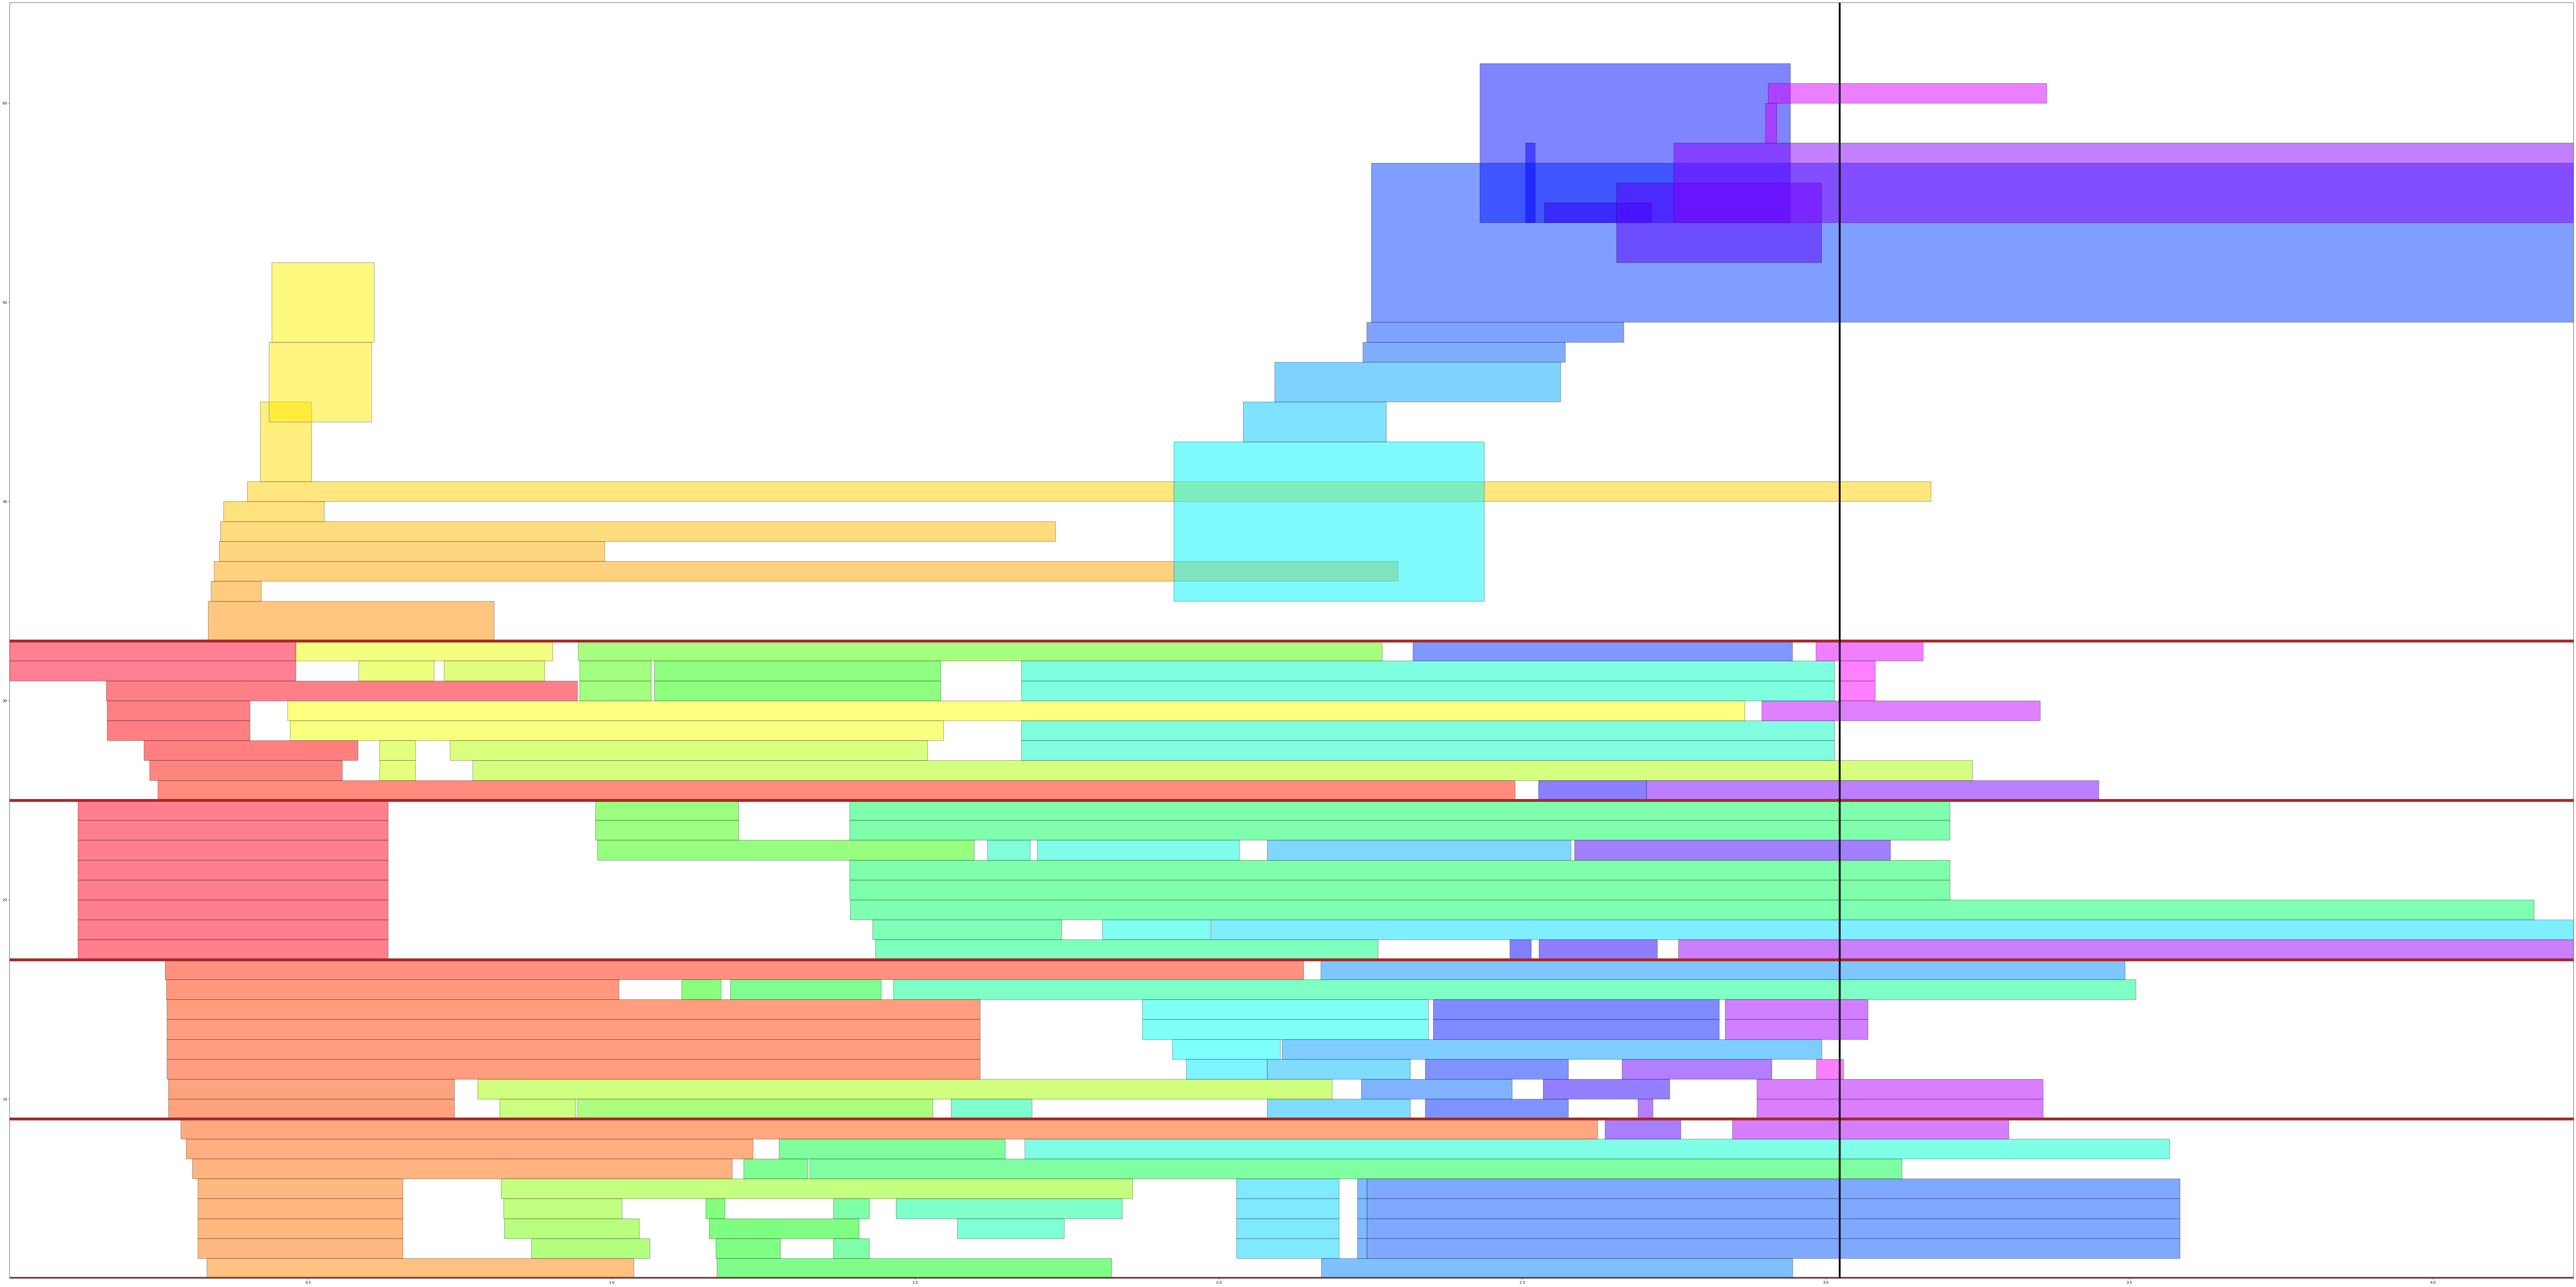

In [9]:
# NO WAIT
run_config['waiting_policy'] = 'constant'
# 15 seconds (due to real life system delays)
run_config['waiting_factor'] =  15/3600 #constant_factor
run_config['loop'] = 0
run_config['long_job_thres'] = -1
run_config['preempt_cloud_ratio'] = -1

asdf = run_simulator(jobs_100, run_config)
plot_trace_spacetime_and_spillover(asdf, 4)

# Constant-Wait

598.7108695652174


Jobs progress: 100%|██████████| 115/115 [00:00<00:00, 14925.43it/s]

Sched Policy    Waiting Policy                  # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  ----------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            constant-0.16630857487922707                  4             37.0611            13.9564        0.067395    0.760008      2.0338     2.77306               0.867517               1.07291


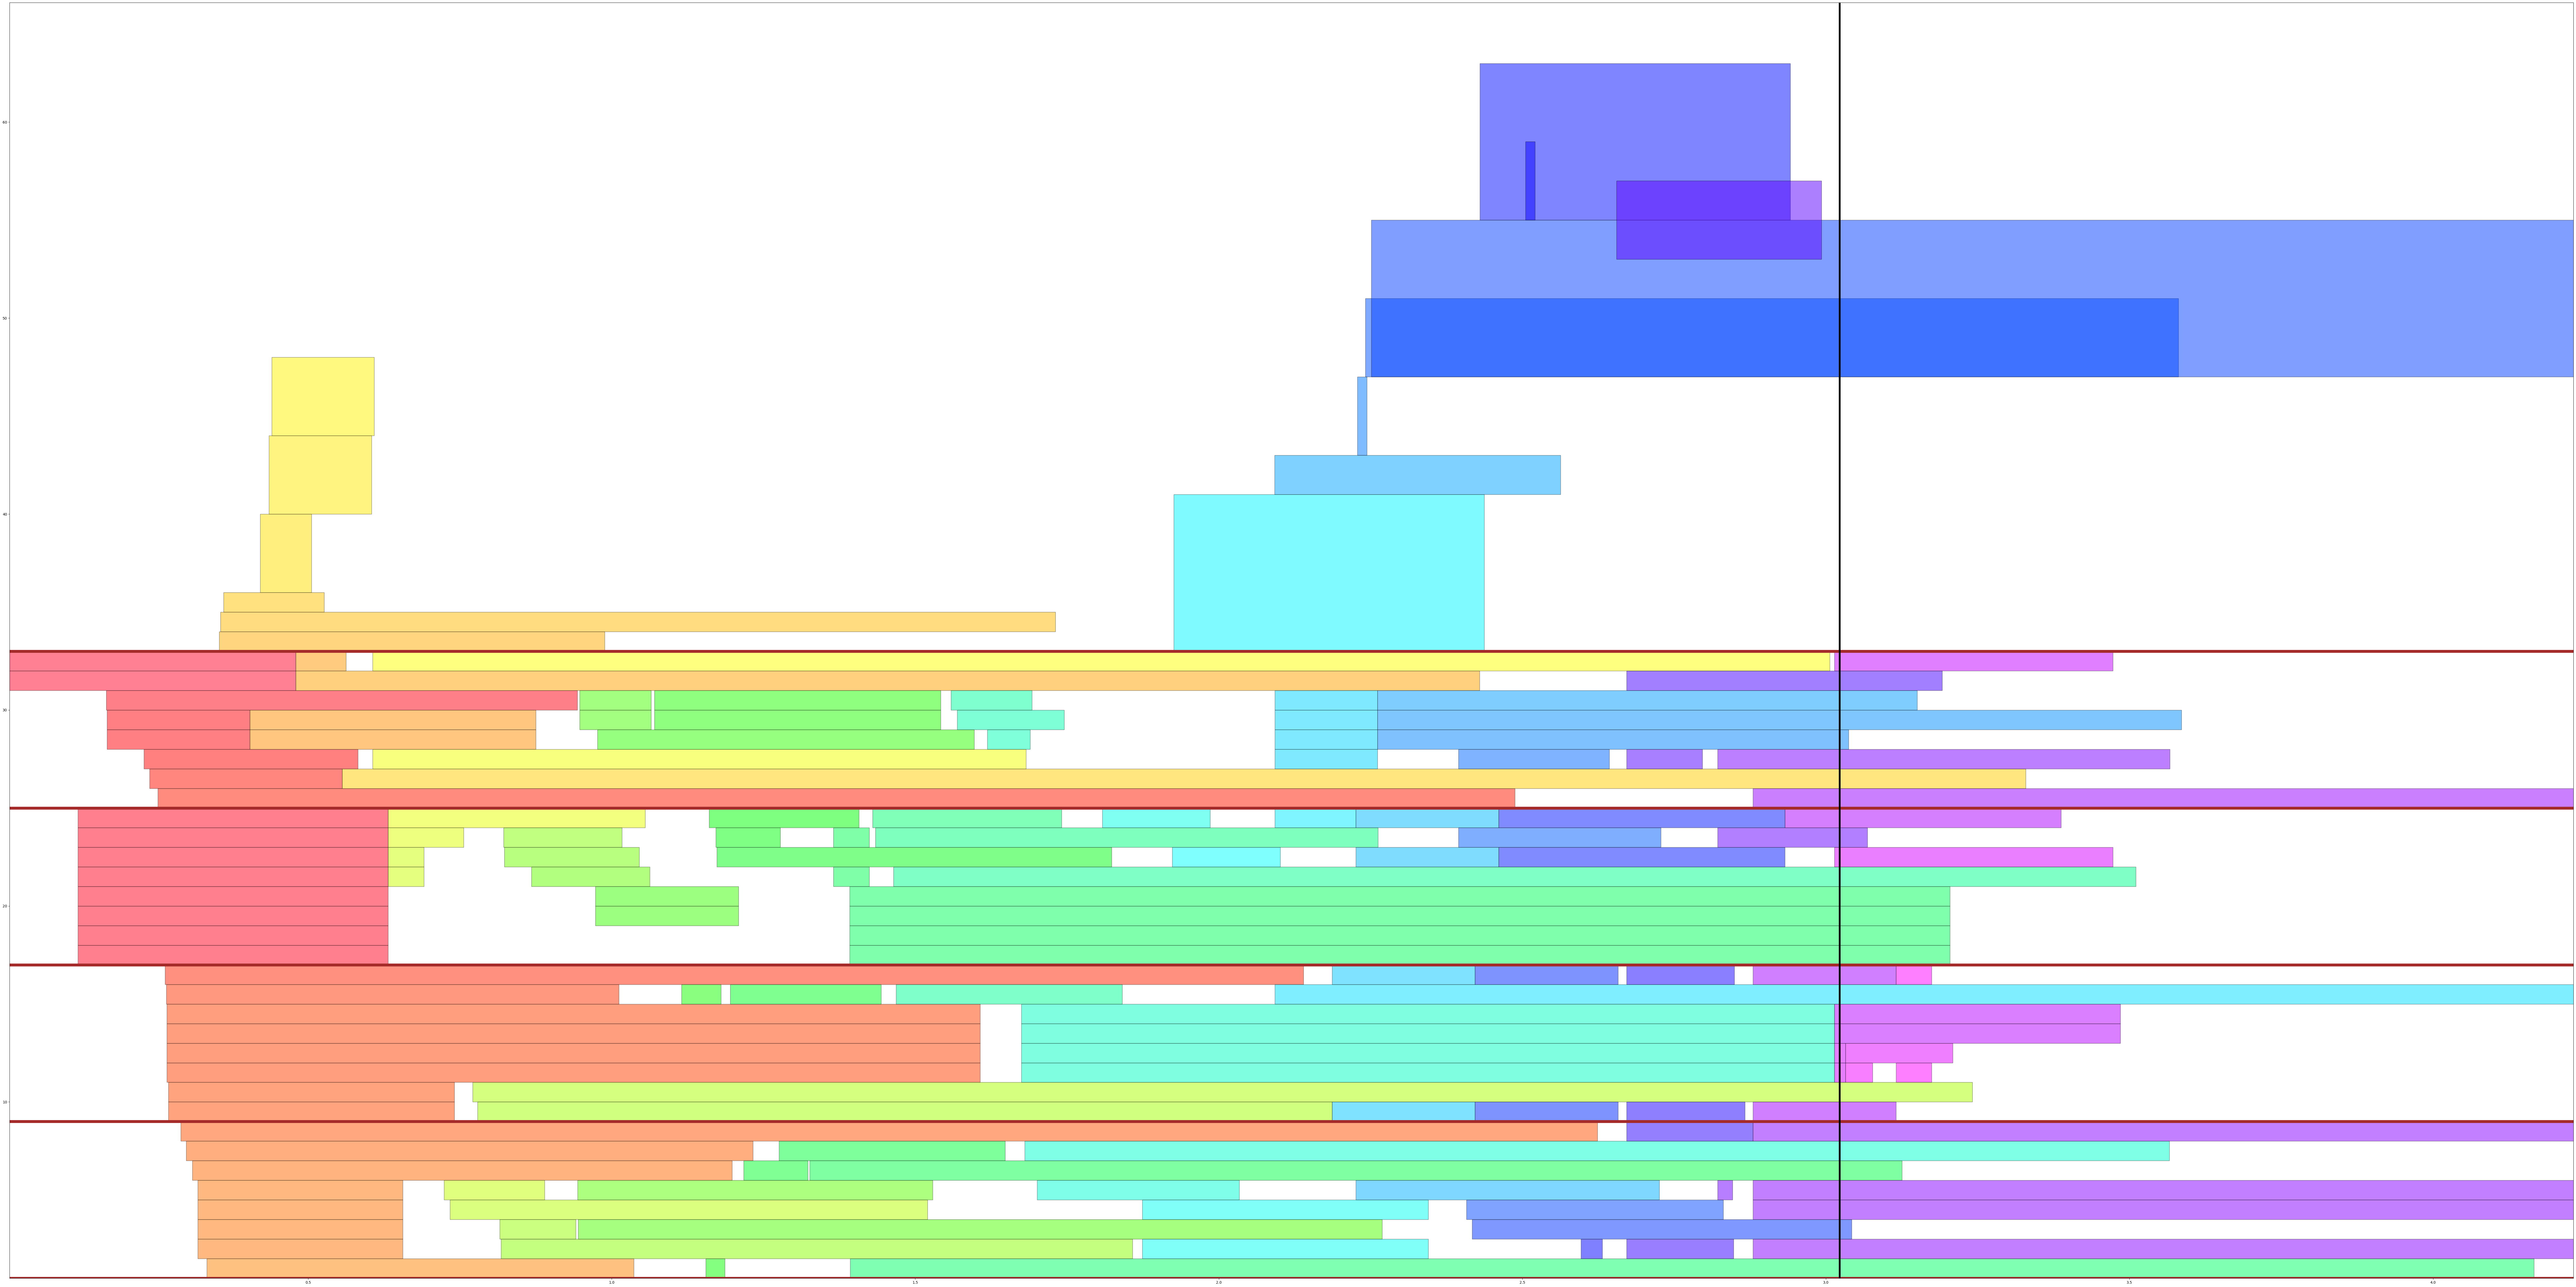

In [10]:
# Constant Wait
run_config['waiting_policy'] = 'constant'
constant_factor =  np.mean([j.runtime for j in jobs_100])/4
print(constant_factor*3600)
run_config['waiting_factor'] =  constant_factor
run_config['loop'] = 0
run_config['long_job_thres'] = -1
run_config['preempt_cloud_ratio'] = -1

asdf = run_simulator(jobs_100, run_config)
plot_trace_spacetime_and_spillover(asdf, 4)

# Starburst

Jobs progress: 100%|██████████| 115/115 [00:00<00:00, 14834.54it/s]


Sched Policy    Waiting Policy                     # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  -------------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_cost-0.14303482587064678                  4             15.4669            5.82449       0.0556454    0.748258     2.04611     2.92956               0.870119              0.978245


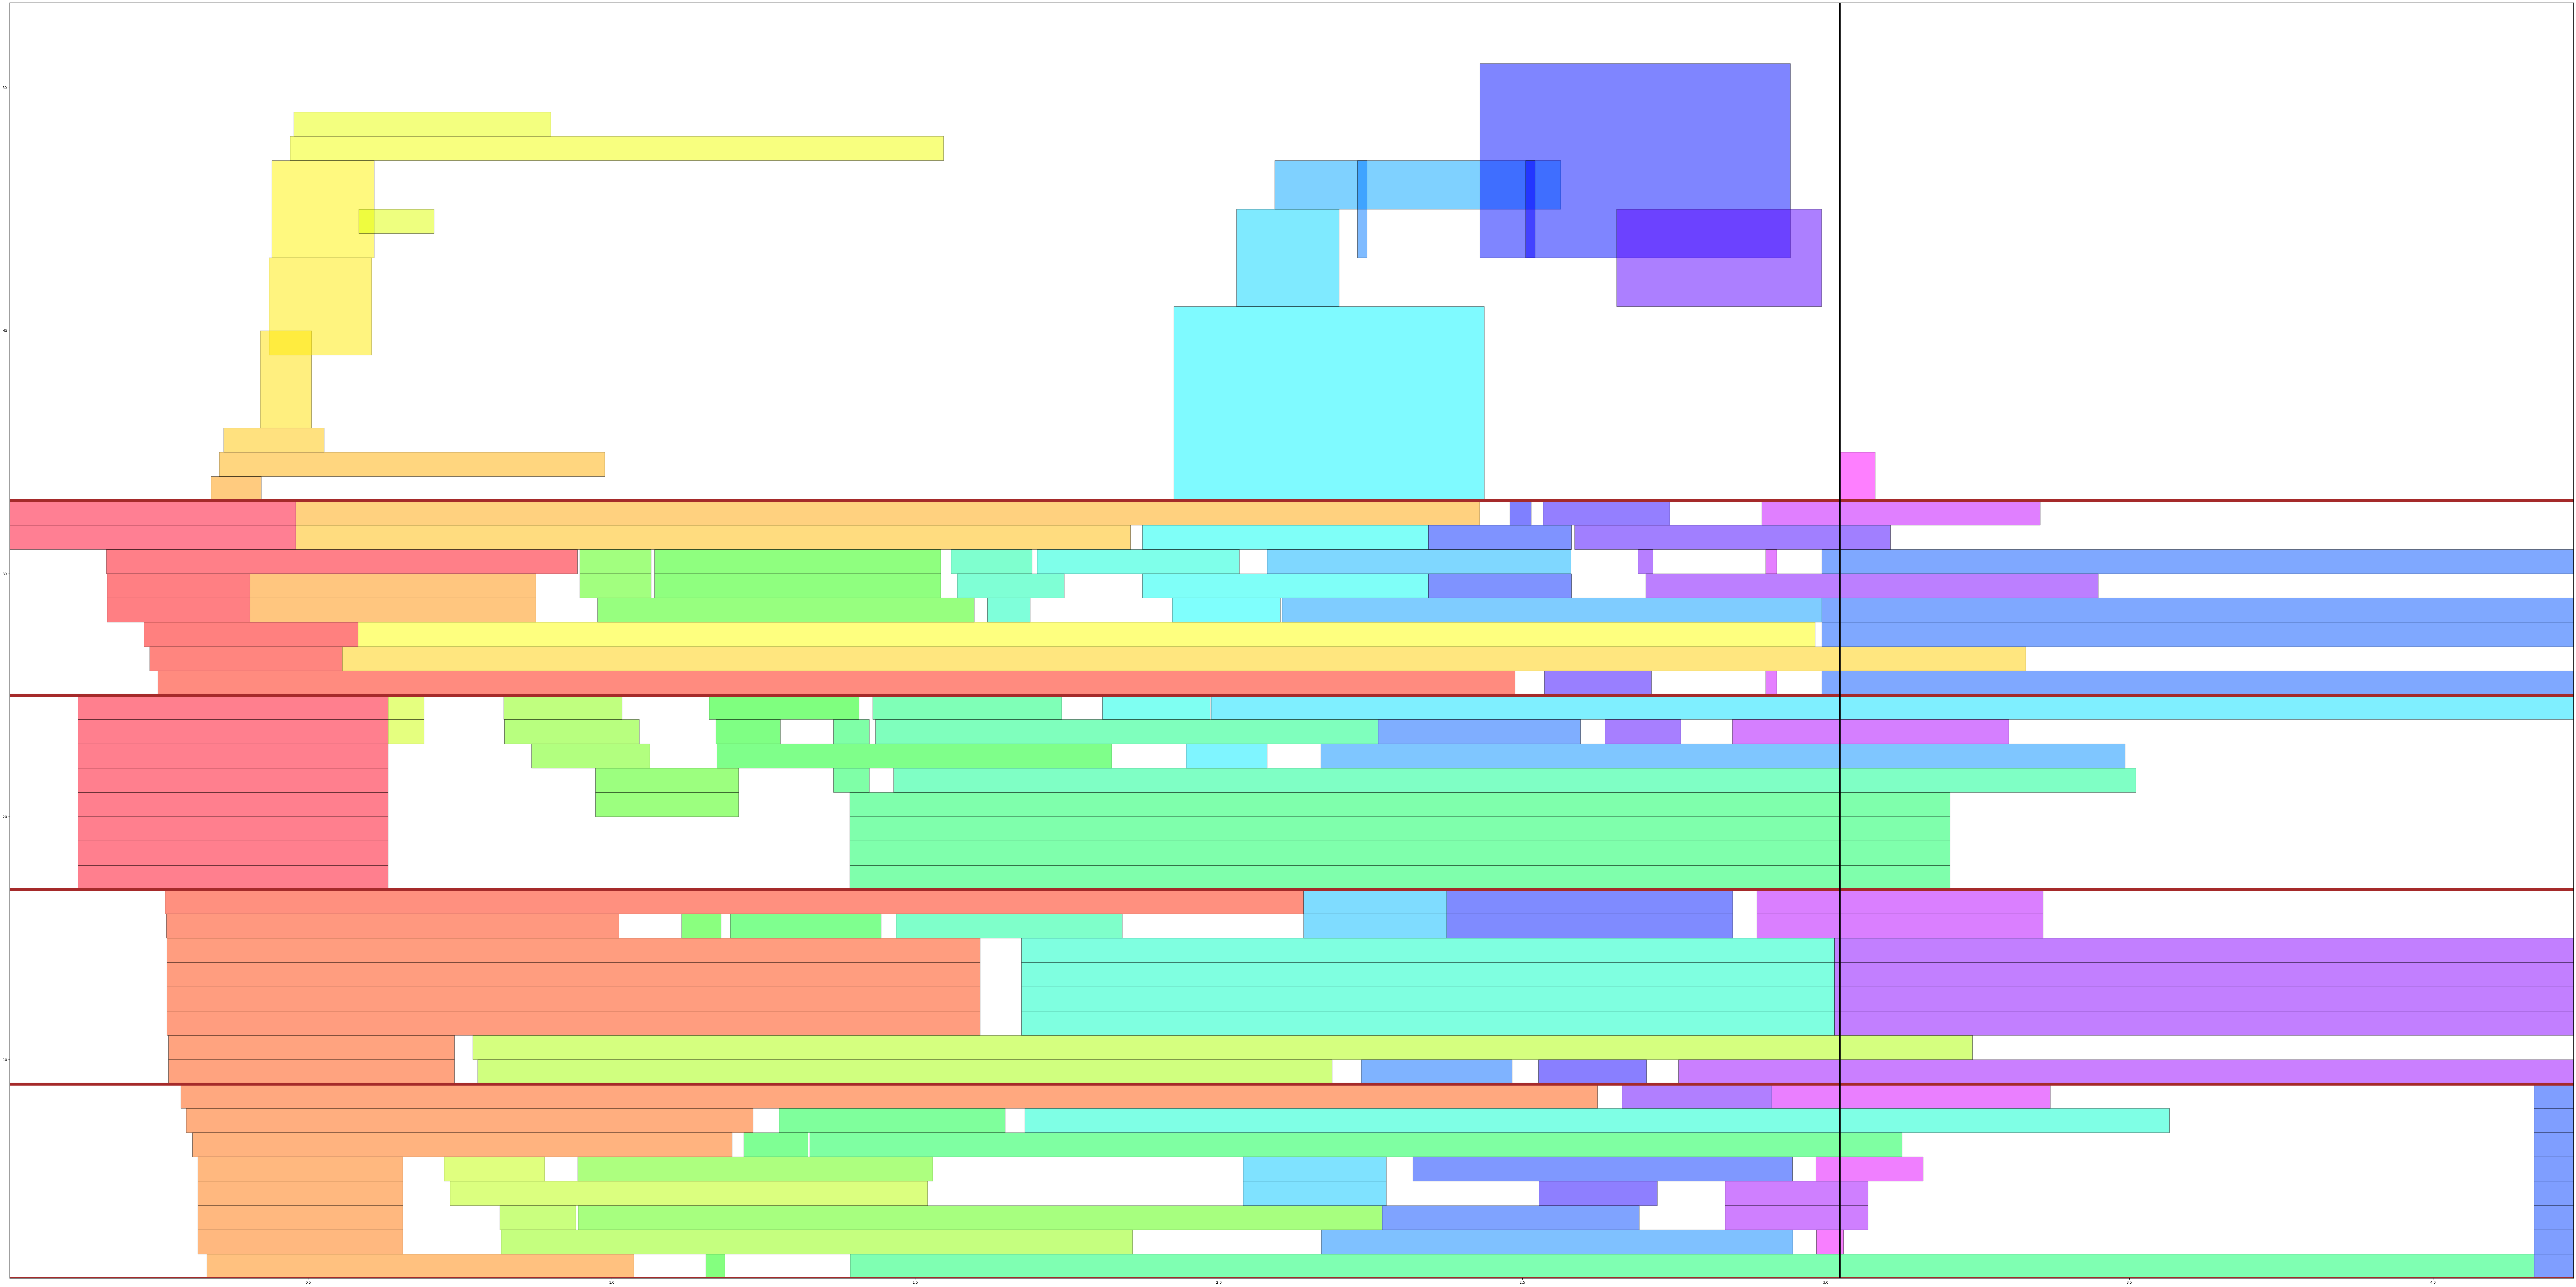

In [13]:
run_config['waiting_policy'] = 'linear_cost'
avg_job_size = sum([j.num_gpus for j in jobs_100])/len(jobs_100)
compute_wait_coeff = 0.25/avg_job_size
run_config['waiting_factor'] =  compute_wait_coeff
run_config['loop'] = 1
asdf1 = run_simulator(jobs_100, run_config)
plot_trace_spacetime_and_spillover(asdf1, 4)

# Starburst w/ No Time Estimator

0.09515167219458266


Jobs progress: 100%|██████████| 115/115 [00:00<00:00, 11622.49it/s]

Sched Policy    Waiting Policy                         # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    90th JCT    99th JCT    Cluster Utilization    System Utilization
--------------  -----------------------------------  -----------------  ------------------  -----------------  --------------  ----------  ----------  ----------  ---------------------  --------------------
fifo            linear_capacity-0.09515167219458266                  4             10.5272            3.96431        0.096808    0.789421     2.11175     2.85639               0.876121              0.932235


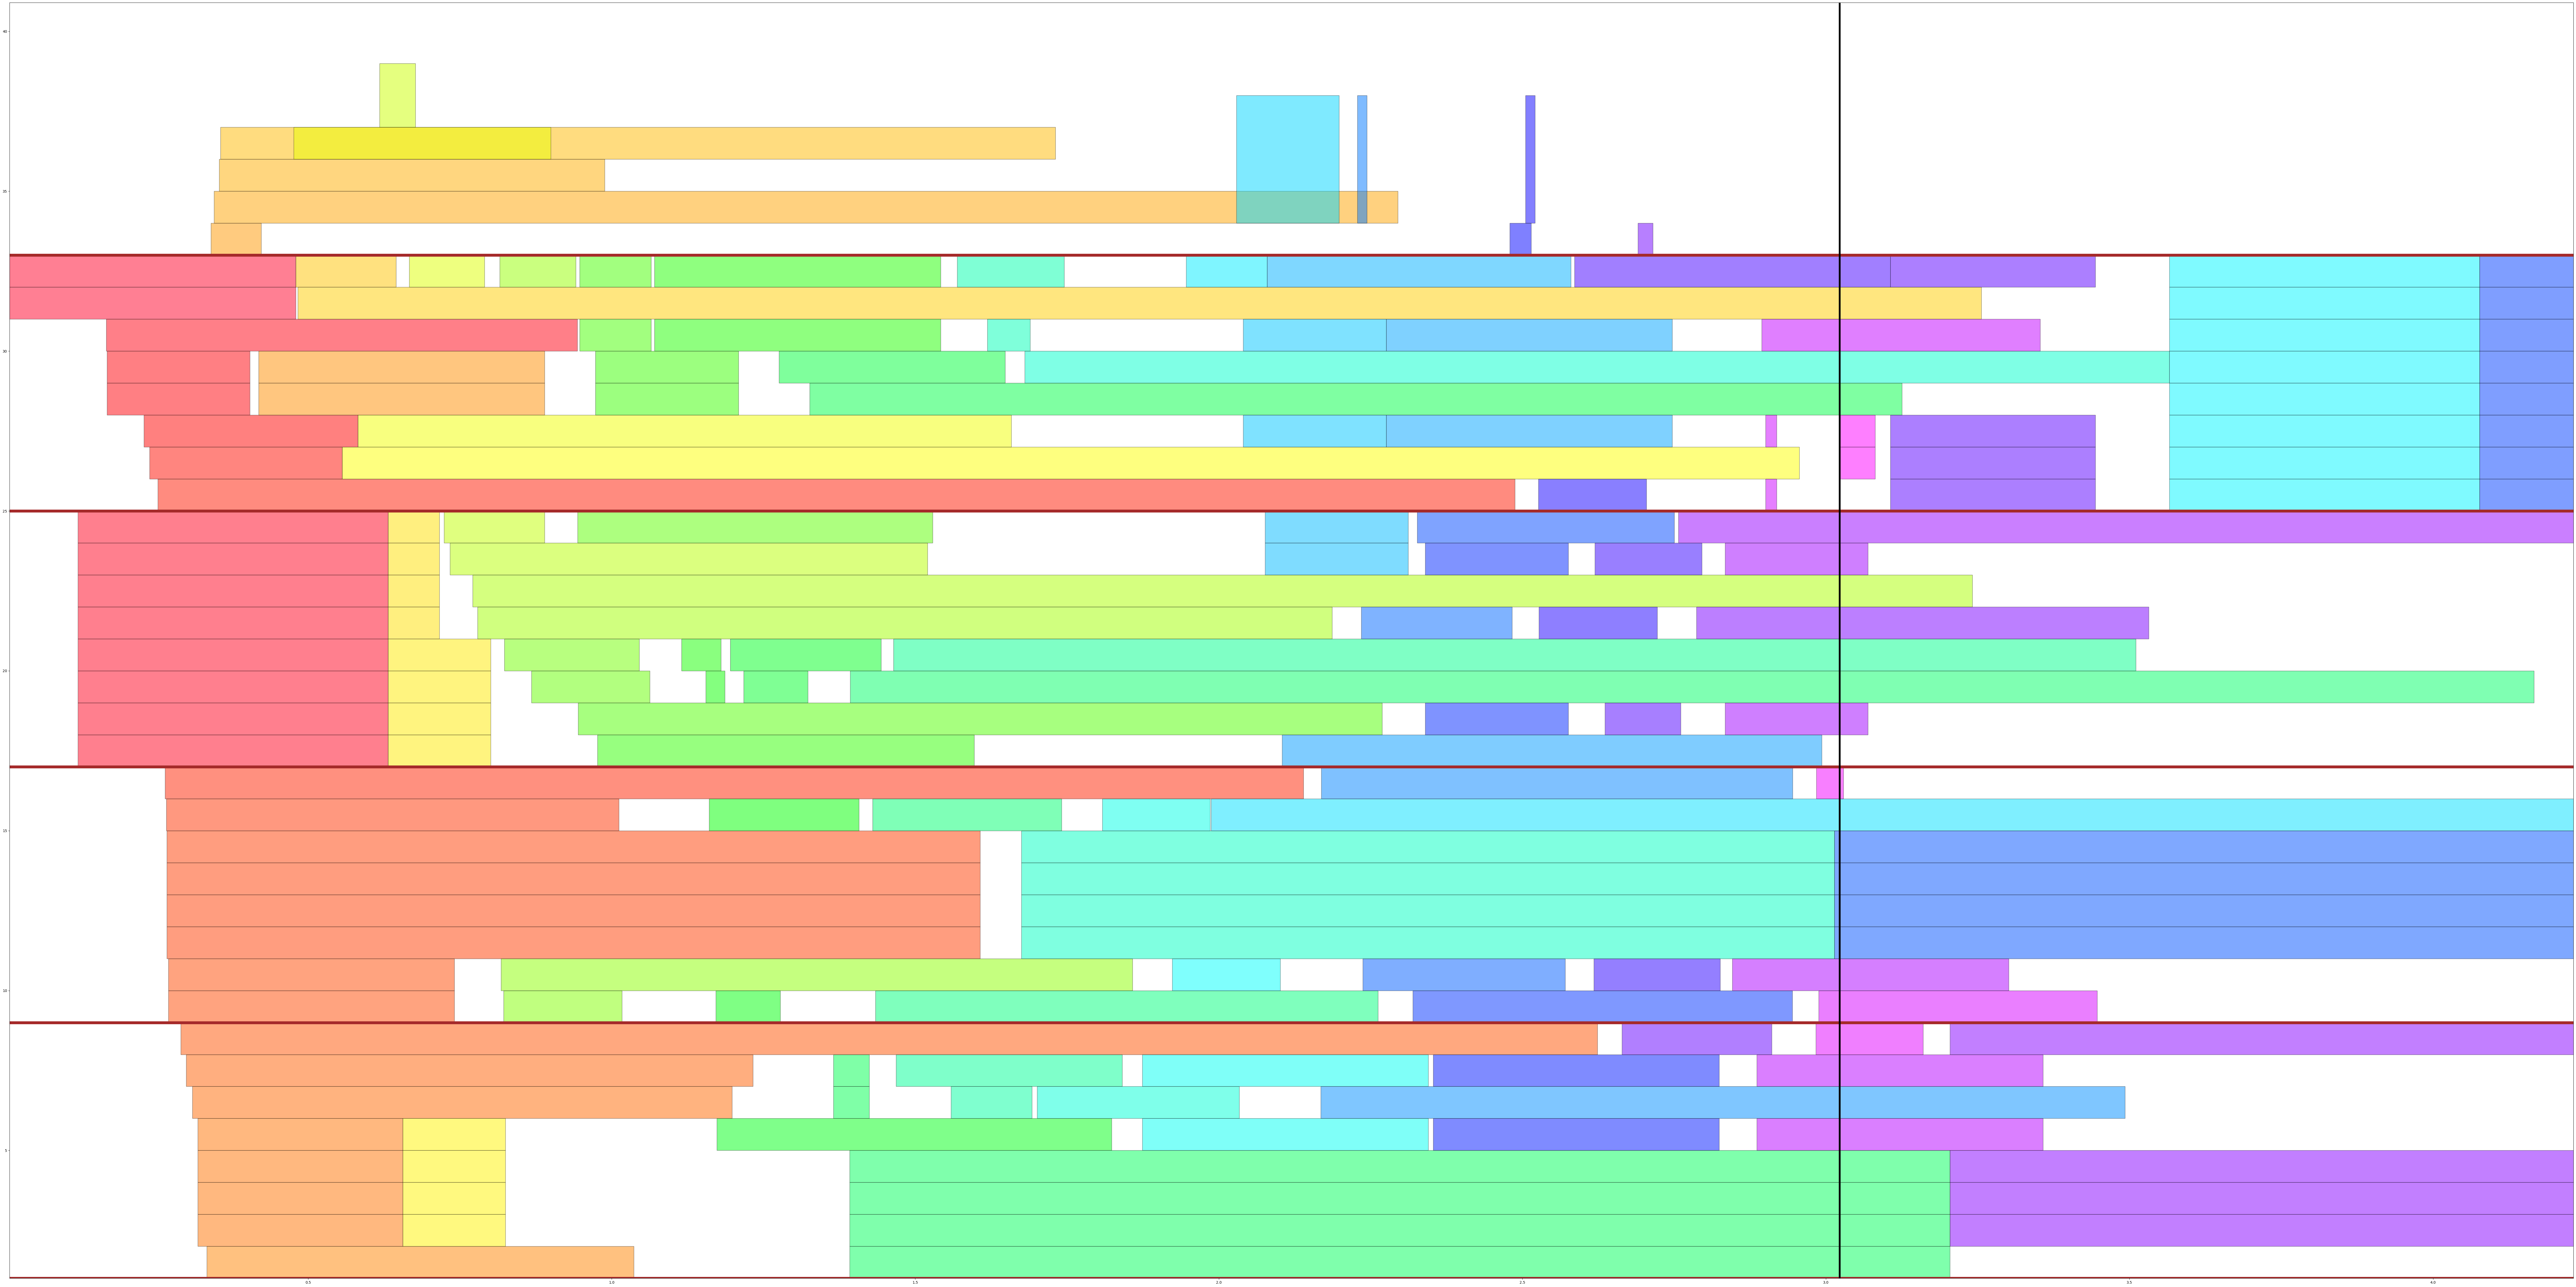

In [14]:
run_config['waiting_policy'] = 'linear_capacity'
resource_wait_coeff = 0.25 * np.mean([j.runtime for j in jobs_100]) / np.mean([j.num_gpus for j in jobs_100])
print(resource_wait_coeff)
run_config['waiting_factor'] = resource_wait_coeff
run_config['loop'] = 1
run_config['long_job_thres'] = 5/60
run_config['preempt_cloud_ratio'] = 3

asdf1 = run_simulator(jobs_100, run_config)
plot_trace_spacetime_and_spillover(asdf1, 4)

# total_wait = 0
# for i in range(len(asdf1['idx'])):
#     if asdf1['state'][i] == 'LOCAL':
#         total_wait += asdf1['deadline'][i] - asdf1['runtime'][i] - asdf1['arrival'][i]
# print(total_wait)